This notebook is the copy of flow_matching notebook, but the training set is limited to 0 -> 180 degrees. The goal is to see how the model behaves for the other half of the circle.

In [11]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from tqdm.notebook import tqdm

from src.model. models import DBModel
from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

In [12]:
import pandas as pd

class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.groupby("angle").head(100)
        self.dataset = self.dataset[self.dataset["angle"] <= 180]
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx], dtype=torch.int64)

        return weights, angle

In [13]:
class Flow(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Flow, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(36, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, 33)
        )
    
    def forward(self, x):
        return self.layers(x)

In [14]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0


def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
epochs = 1000
lr = 1e-3
batch_size = 100
hidden_dim = 1024


# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow(1024)
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../../models/generators/"
model_path = path + "flow_conditional_half.pth"


In [16]:
losses = []
for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(flow.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 4.015744686126709
Epoch 10: Loss 2.9906511306762695
Epoch 20: Loss 2.800943374633789
Epoch 30: Loss 3.0214531421661377
Epoch 40: Loss 2.692748546600342
Epoch 50: Loss 2.9993340969085693
Epoch 60: Loss 2.476680040359497
Epoch 70: Loss 3.052706003189087
Epoch 80: Loss 2.932685375213623
Epoch 90: Loss 2.4033091068267822
Epoch 100: Loss 2.6999330520629883
Epoch 110: Loss 3.046506881713867
Epoch 120: Loss 2.942686080932617
Epoch 130: Loss 2.897650957107544
Epoch 140: Loss 2.8405025005340576
Epoch 150: Loss 2.7482659816741943
Epoch 160: Loss 2.7119104862213135
Epoch 170: Loss 2.771193265914917
Epoch 180: Loss 3.015200614929199
Epoch 190: Loss 2.803532123565674
Epoch 200: Loss 2.352109432220459
Epoch 210: Loss 2.400683879852295
Epoch 220: Loss 2.66195011138916
Epoch 230: Loss 2.561847686767578
Epoch 240: Loss 2.7431533336639404
Epoch 250: Loss 2.6986281871795654
Epoch 260: Loss 2.4599385261535645
Epoch 270: Loss 2.6695733070373535
Epoch 280: Loss 2.499391555786133
Epoch 290: Los

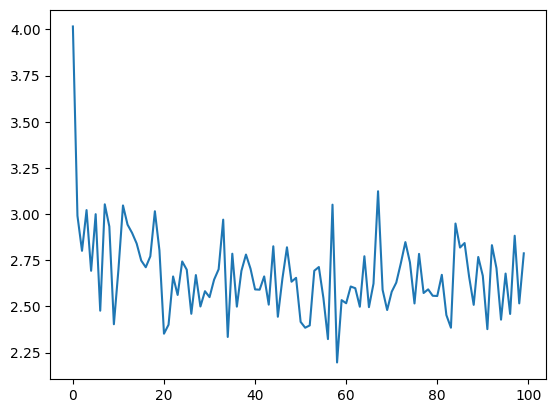

In [17]:
plt.plot(losses)

## Conditional Generation

In [18]:
def generate(model, angle, num_iter=100):
    x = gaussian.sample((1,))
    angle = torch.tensor([angle*torch.pi/180])
    for i in np.linspace(0, 1, num_iter, endpoint=False):
        t = torch.tensor([i], dtype=torch.float32)
        sin = torch.sin(angle)
        cos = torch.cos(angle)
        path = model(torch.cat([x, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        x += (0.01 * path)
    return x.detach()

In [ ]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

def slider(angle):
    x = generate(flow, angle, num_iter=100)[0]
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    plot_decision_boundary(x, X_rotated, y, title=f"{angle}° degrees")

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

In [20]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()
flow.to("cpu")

accuracies = []
angles = [225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in tqdm(range(1000)):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_28892\2039616010.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean accuracy: 61.65926666666666


<Axes: ylabel='Density'>

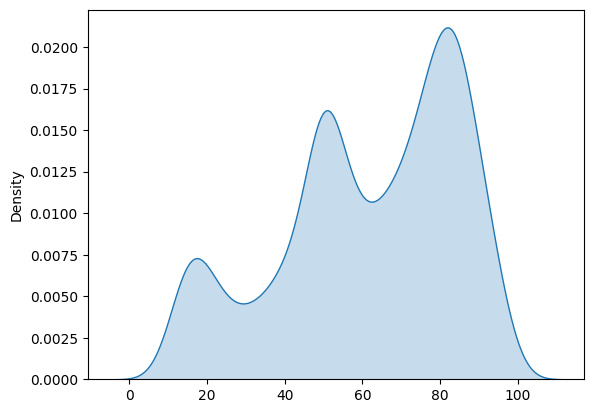

In [21]:
sns.kdeplot(accuracies, fill=True)